In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

Longitud del texto: 5000, vocabulario: 53

=== Experimento 1 ===


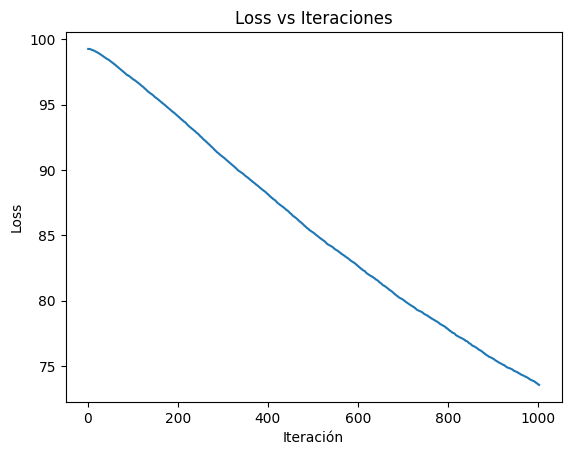

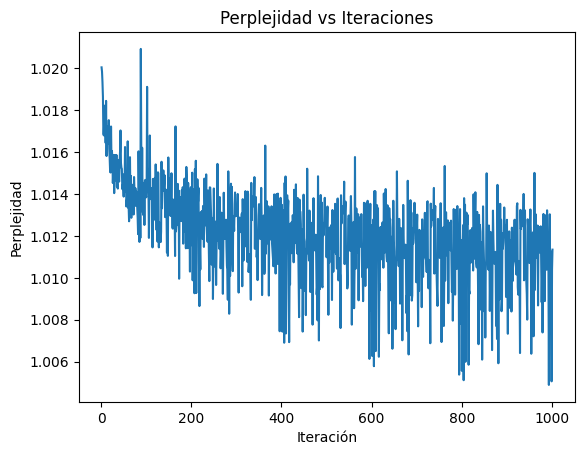

→ Texto generado:
ur: to for tous beot sor titizen:
EMiAg?
-Fial swhl muupstd n hiotd manl thal baker widime-e
gok curst, and
Set untllyoslivevans id
Ag ucanzinsculis
ver:
ODit  ramf hisughergy ulverst

alr,, untizen is bdty
Thintouven:
Whold.

Tr Youlve sthe?

Firs, s.

he r aml oser cade the asaldve
The ratieDcive


=== Experimento 2 ===


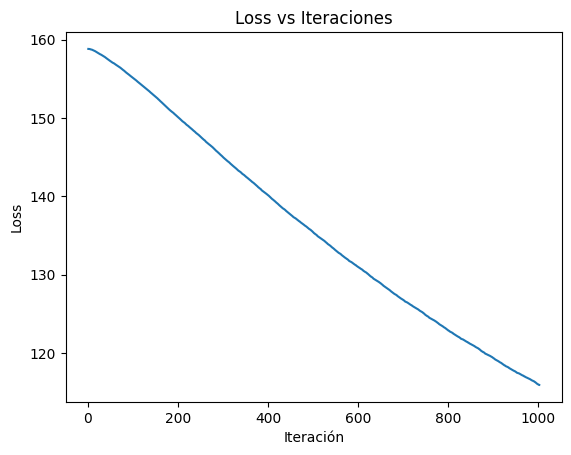

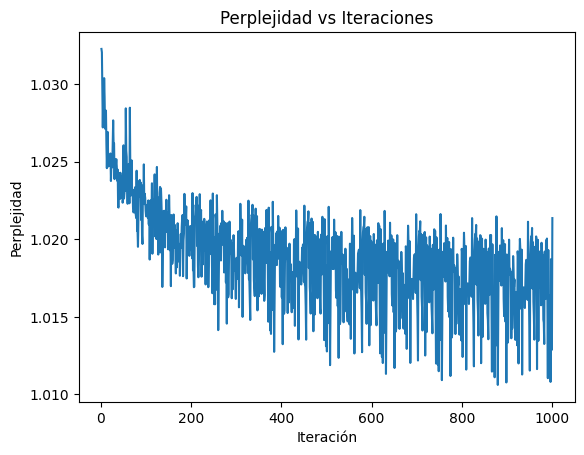

→ Texto generado:
Csie  her, Citizen:
Le shanast Cicires, I very y to be babee, yek wafo somr bo nourder on weds ere dn t pwecizen:
coungo bnute morell mo thlimhe Lur aw?
Yoh to's, whes cgoly,
I-:
The' cf, ,rm dirl penmL tharled
corvet, che rowe sursall cheCinith

EFirsa morlE
Ro ael;
Fheldrscyolc'ack sonlelist,, Rea

=== Experimento 3 ===


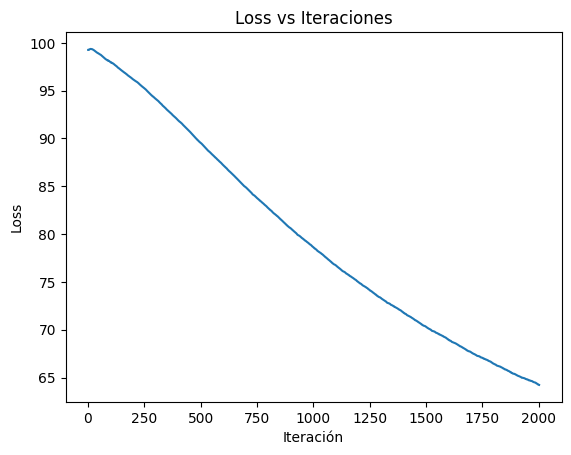

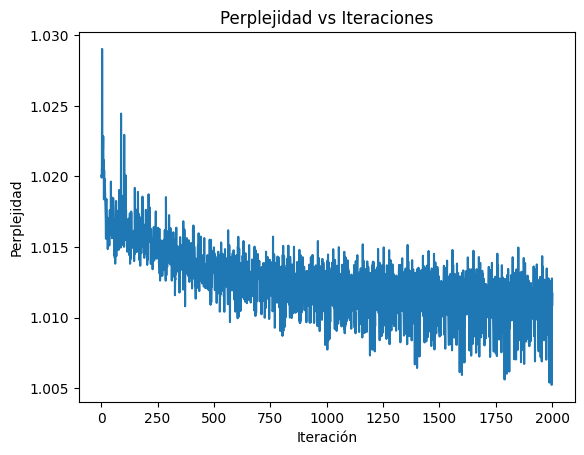

→ Texto generado:
 the itozing bitl st und. ron: uh-nethes, aure Aon cout Coust he yourr-t. Awacvord
ME.
SIpfou.

wl-:
Tull be sus.

Firhs hat if anpe dsthirs beld,s, dperitizen:W:
A.

Filss, mather ab akor the fti!d poat he mitiny itary, us er the Iny.

Aen:
Wor mCithaed yout andhed.

Afred the Cith anst, panst
mitf


In [ ]:
# ---------------------------------------------------------------------
# Cargar texto tiny Shakespeare
# ---------------------------------------------------------------------
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text[:5000]   # usa solo los primeros 5000 caracteres para que sea más rápido

chars = list(set(text))
data_size, vocab_size = len(text), len(chars)
print(f"Longitud del texto: {data_size}, vocabulario: {vocab_size}")

# Diccionarios char↔int
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# ---------------------------------------------------------------------
# Clase RNN: generacion de textos
# ---------------------------------------------------------------------
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))
        
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)

    def forward_pass(self, inputs, targets, hprev):
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0
        for t in range(len(inputs)):
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss -= np.log(p[t][targets[t], 0])
        return loss, x, h, p

    def backpropagation(self, x, h, p, targets, *, do_clipping):
        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])
        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] -= 1
            dWhy += dy @ h[t].T
            dby += dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh += dhraw
            dWxh += dhraw @ x[t].T
            dWhh += dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw
        if do_clipping:
            for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
                np.clip(dpara, -5, 5, out=dpara)
        return dWxh, dWhh, dWhy, dbh, dby

    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(
            ['Wxh', 'Whh', 'Why', 'bh', 'by'],
            [dWxh, dWhh, dWhy, dbh, dby],
            ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):
            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) -
                    self.learning_rate * dpara / np.sqrt(getattr(self, mem) + 1e-8))

    def make_sample(self, hprev, seed_ix, n):
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes, h = [], np.copy(hprev)
        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p=p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

    def plot(self, values, tipo):
        plt.plot(range(1, len(values) + 1), values)
        plt.title(f'{tipo} vs Iteraciones')
        plt.xlabel('Iteración')
        plt.ylabel(tipo)
        plt.show()

    def train(self, inputs, char_to_int, int_to_char, max_iter=2000, *,
              do_plot_loss=True, do_plot_perplexity=True, do_clipping=True):
        iter_num, pos = 0, 0
        loss_hist, perplex_hist = [], []
        loss_hist.append(- np.log(1 / self.n_x) * self.seq_length)
        hprev = np.zeros((self.n_h, 1))
        while iter_num <= max_iter:
            if pos + self.seq_length + 1 >= len(inputs):
                pos = 0
                hprev = np.zeros((self.n_h, 1))
            batch_in = [char_to_int[ch] for ch in inputs[pos:pos + self.seq_length]]
            batch_out = [char_to_int[ch] for ch in inputs[pos + 1:pos + self.seq_length + 1]]
            pos += self.seq_length
            loss, x, h, p = self.forward_pass(batch_in, batch_out, hprev)
            loss_hist.append(loss_hist[-1] * 0.999 + loss * 0.001)
            perplex_hist.append(np.exp(loss / len(inputs)))
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, batch_out, do_clipping=do_clipping)
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]
            iter_num += 1
        # sample
        sample_ix = self.make_sample(hprev, batch_out[-1], 300)
        texto = ''.join(int_to_char[ix] for ix in sample_ix)
        if do_plot_loss:
            self.plot(loss_hist, "Loss")
        if do_plot_perplexity:
            self.plot(perplex_hist, "Perplejidad")
        return loss_hist, texto, perplex_hist

# ---------------------------------------------------------------------
# Experimentos con distintos hiperparámetros
# ---------------------------------------------------------------------
configs = [
    {"n_h": 64, "seq_length": 30, "lr": 0.01, "max_iter": 1500, "clip": True},
    {"n_h": 128, "seq_length": 25, "lr": 0.005, "max_iter": 2000, "clip": False},
    {"n_h": 32, "seq_length": 50, "lr": 0.1, "max_iter": 1200, "clip": True},
    {"n_h": 256, "seq_length": 40, "lr": 0.001, "max_iter": 2500, "clip": True},
    {"n_h": 128, "seq_length": 35, "lr": 0.02, "max_iter": 1800, "clip": False},
    {"n_h": 64, "seq_length": 45, "lr": 0.03, "max_iter": 1600, "clip": True},
]


for i, cfg in enumerate(configs, 1):
    print(f"\n=== Experimento {i} ===")
    rnn = vanillaRNN(n_x=vocab_size, n_h=cfg["n_h"], seq_length=cfg["seq_length"], learning_rate=cfg["lr"])
    loss_hist, texto, perplex = rnn.train(
        text, char_to_int, int_to_char,
        max_iter=cfg["max_iter"], do_clipping=cfg["clip"]
    )
    print(f"→ Texto generado:\n{texto[:500]}")
